In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
45847,NaN,NaN,International,2020-09-22,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45848,NaN,NaN,International,2020-09-23,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45849,NaN,NaN,International,2020-09-24,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


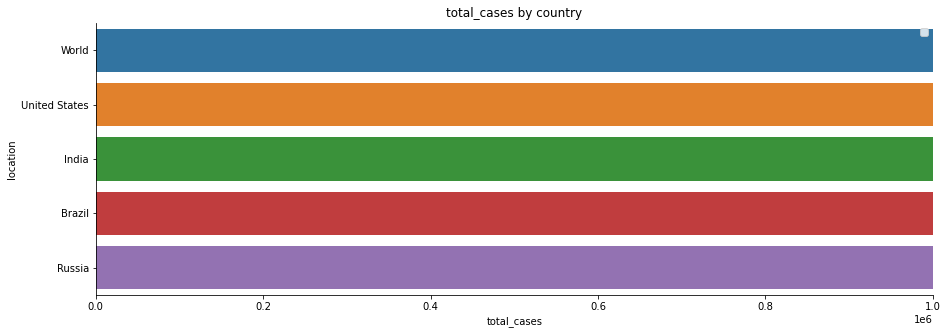

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


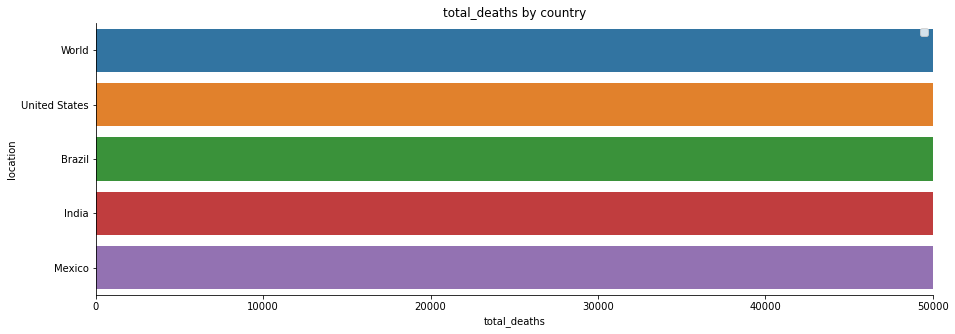

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


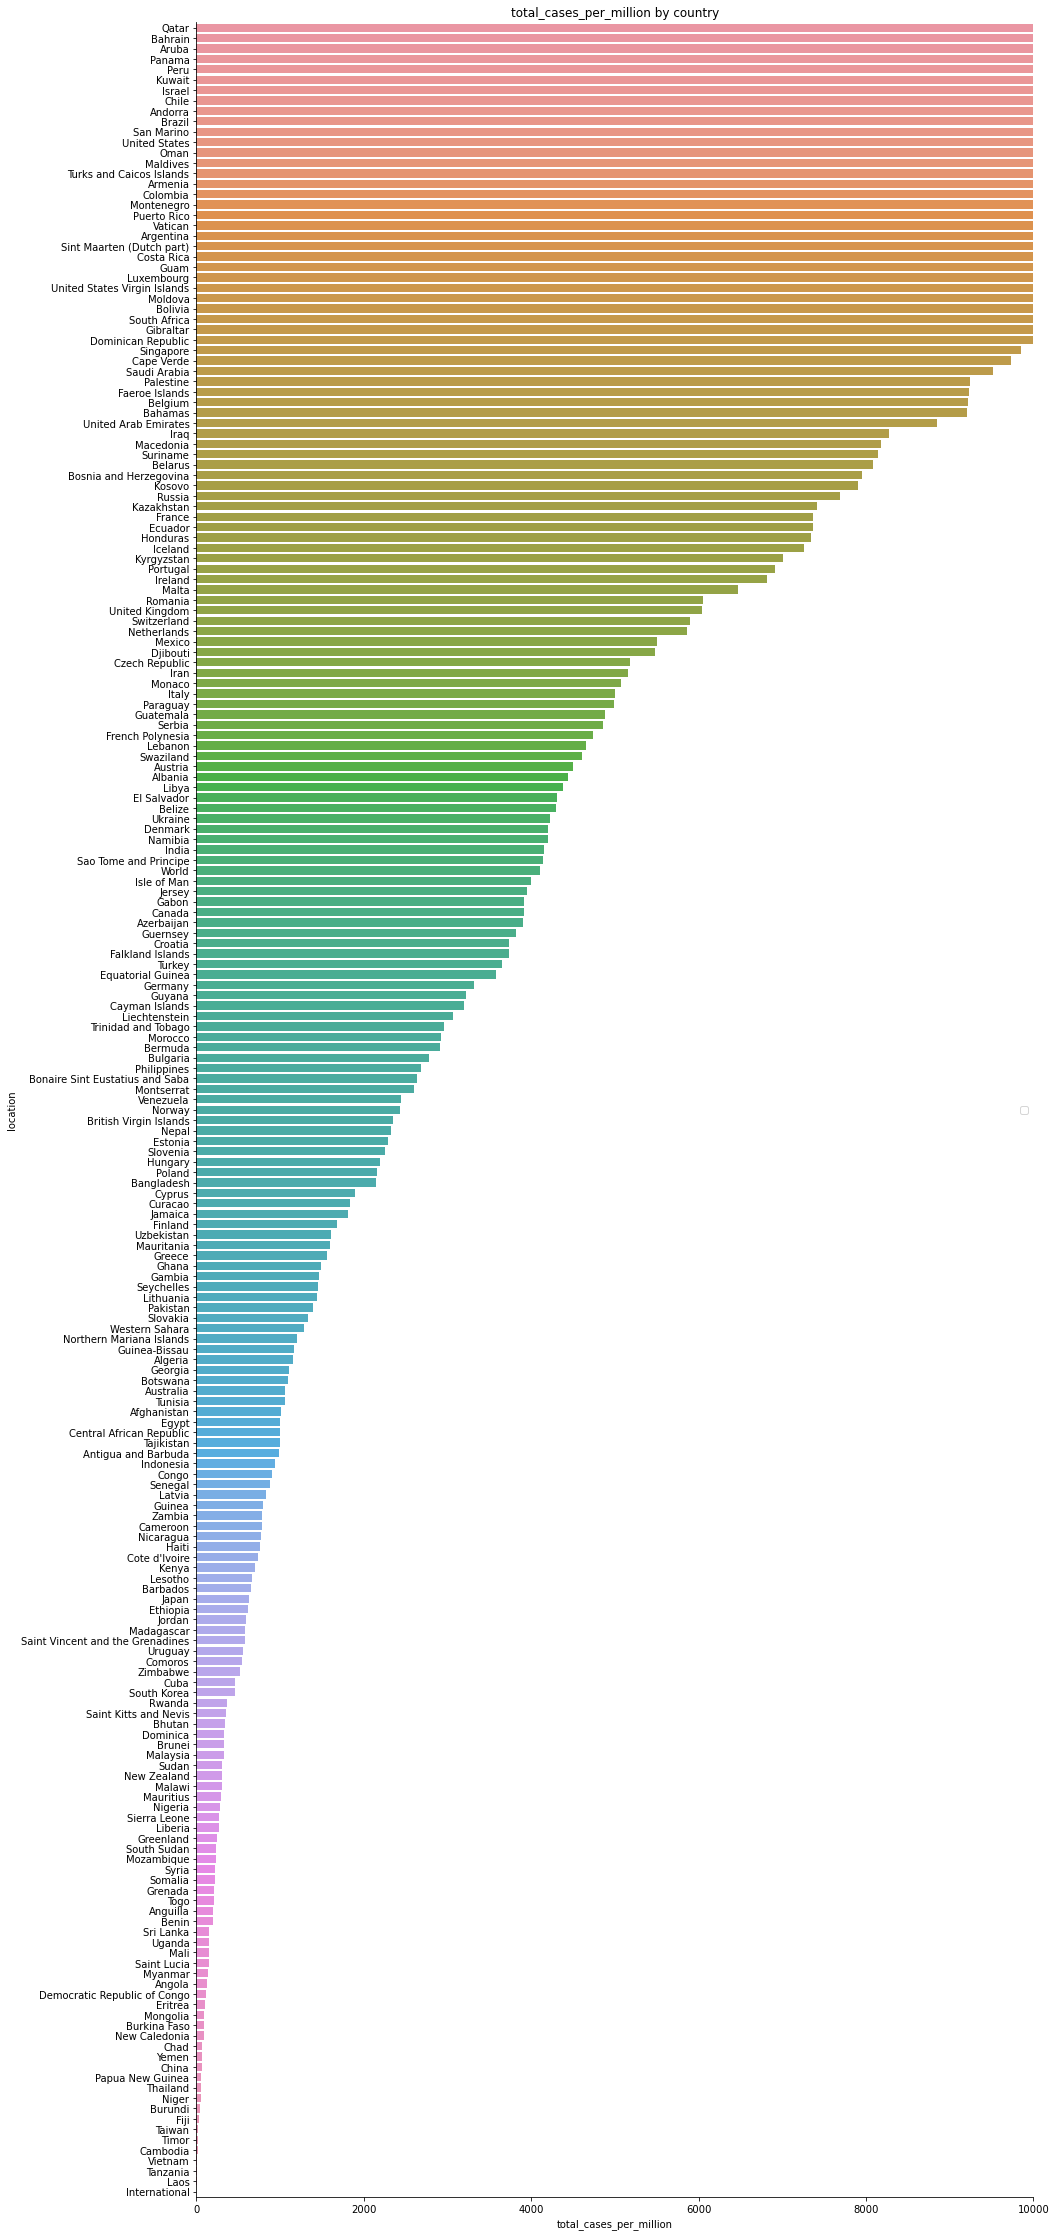

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


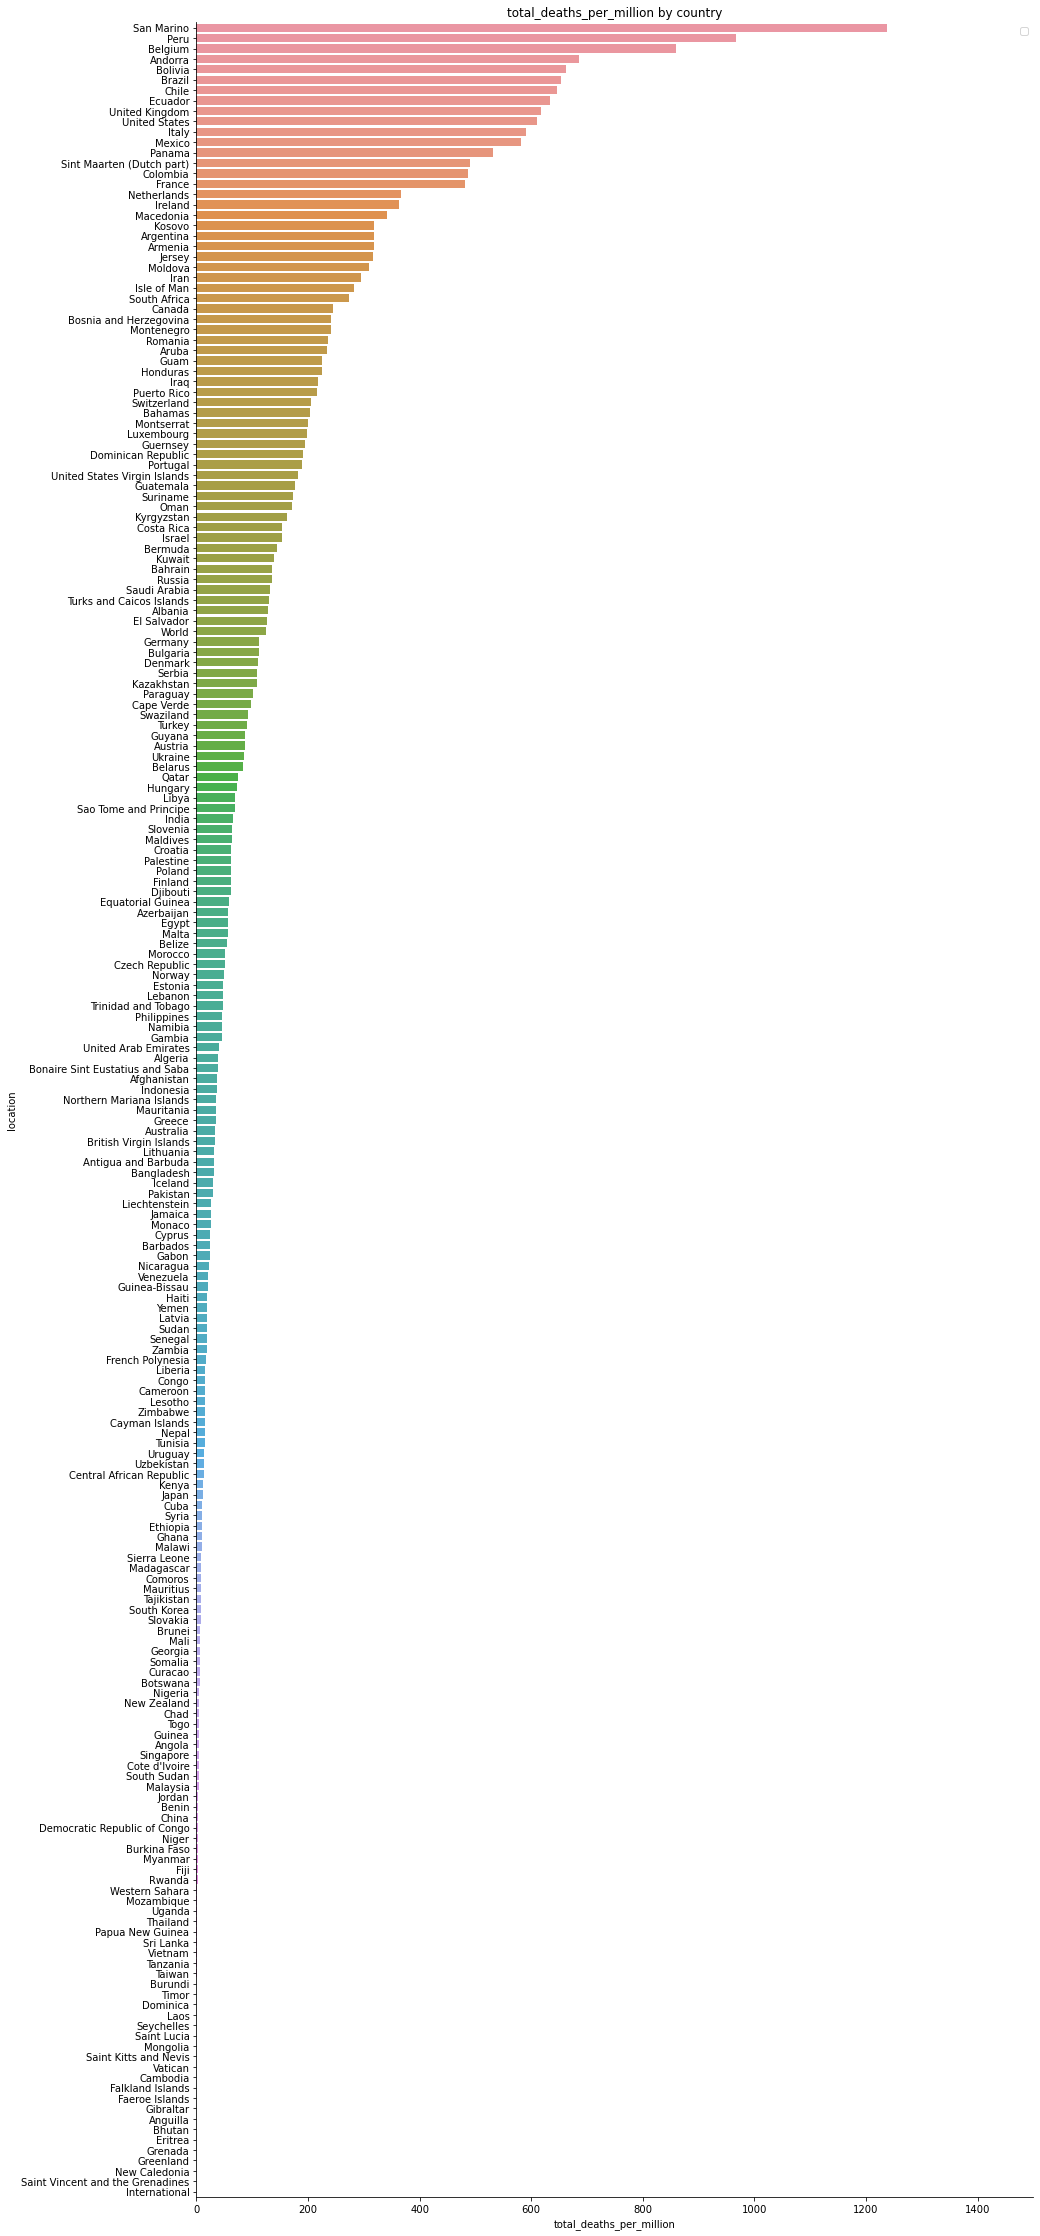

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

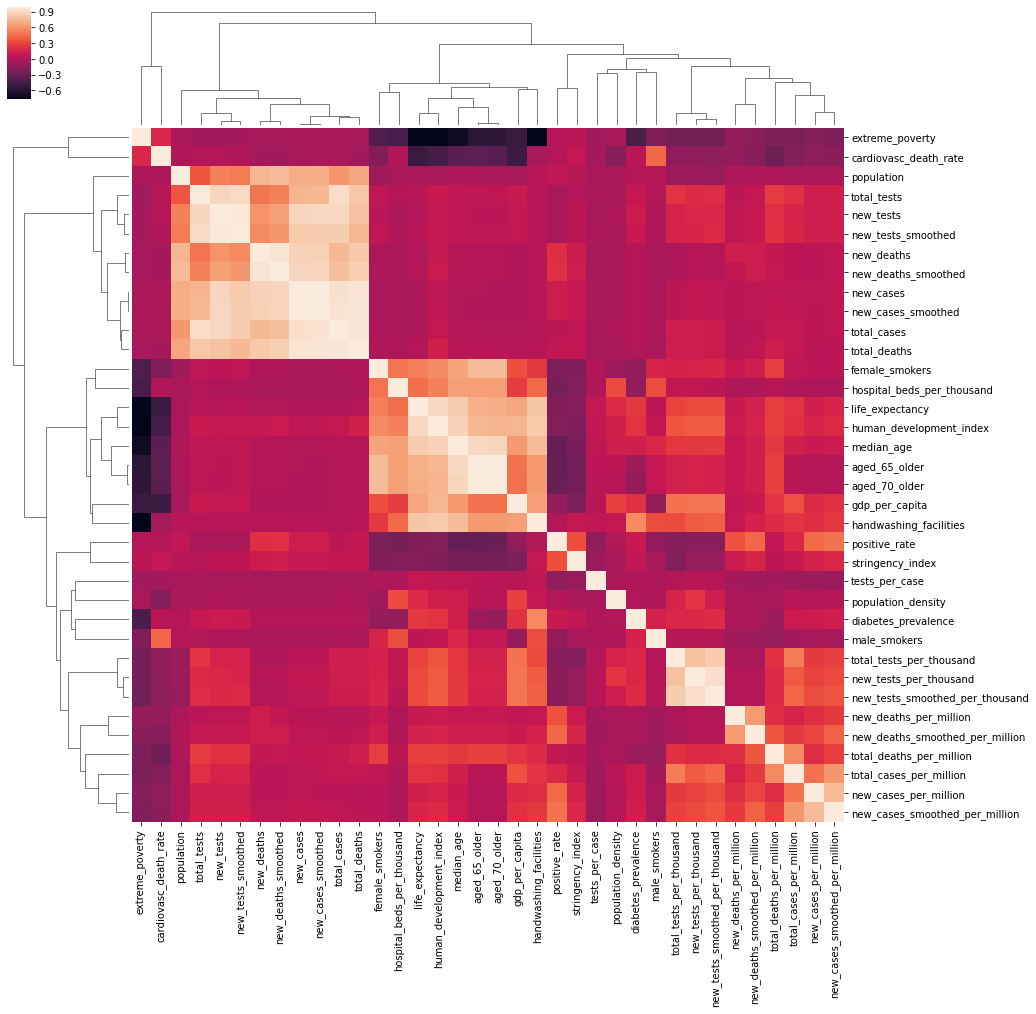

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9984819419501566 (+/- 0.001979246117335301)
Coef :  [1.03121473e+00 8.17538410e-05 8.43591222e-05]
3 Last_days :  [[31392545 31671844 31969439]]
Today :  31969439
Prediction + :  513940
Tomorow :  32483379
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996285815796592 (+/- 0.00014511573497609368)
Coef :  [0.22803726 0.38014669 0.40178341]
3 Last_days :  [[965946 972008 978284]]
Today :  978284
Prediction + :  7918
Tomorow :  986202
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.01935707748828937 (+/- 1.4377649248150373)
Coef :  [-0.72366745  0.76475754  0.96493622]
3 Last_days :  [[458061 468069 481141]]
Today :  481141
Prediction + :  9490
Tomorow :  490631
                                     
--------- Total Death -----------------
                                     
R^2: 0.7401329757265458 (+/- 0.35780101547260845)
Coef :  [-0.74567176  0.78766501  0.95697352]
3 Last_days :  [[31338 31416 31459]]
Today :  31459
Prediction + :  77
Tomorow :  31536
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9662628955121745 (+/- 0.033272205827255125)
Coef :  [-0.33033155 -0.00964559  1.33424158]
3 Last_days :  [[90381 90399 90409]]
Today :  90409
Prediction + :  18
Tomorow :  90427
                                     
--------- Total Death -----------------
                                     
R^2: -32.5714279801475 (+/- 47.37723461146224)
Coef :  [-0.07767053  0.01248477  1.05688052]
3 Last_days :  [[4737 4737 4738]]
Today :  4738
Prediction + :  5
Tomorow :  4743
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9217384768510296 (+/- 0.10955475456178718)
Coef :  [-0.80963921  0.89155018  0.91754233]
3 Last_days :  [[299506 300897 302537]]
Today :  302537
Prediction + :  1231
Tomorow :  303768
                                     
--------- Total Death -----------------
                                     
R^2: -0.2617217558252553 (+/- 1.763689837099588)
Coef :  [-0.81913676  0.89500177  0.92312838]
3 Last_days :  [[35724 35738 35758]]
Today :  35758
Prediction + :  30
Tomorow :  35788
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6542034089460147 (+/- 0.48149712765836006)
Coef :  [-0.24185157  0.13105178  1.11934577]
3 Last_days :  [[671468 682267 693556]]
Today :  693556
Prediction + :  9818
Tomorow :  703374
                                     
--------- Total Death -----------------
                                     
R^2: 0.39517570284970877 (+/- 0.5738459340519021)
Coef :  [-0.72998898  0.64284477  1.08623658]
3 Last_days :  [[30663 30904 31034]]
Today :  31034
Prediction + :  197
Tomorow :  31231
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9256796339612589 (+/- 0.10286788774789733)
Coef :  [0.14331134 0.43138468 0.43784263]
3 Last_days :  [[6857967 6896274 6934204]]
Today :  6934204
Prediction + :  78358
Tomorow :  7012562
                                     
--------- Total Death -----------------
                                     
R^2: 0.9799533031073517 (+/- 0.027041495250693957)
Coef :  [-0.38809083  0.66414315  0.72671891]
3 Last_days :  [[199881 200807 201909]]
Today :  201909
Prediction + :  1071
Tomorow :  202980
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9951240773953668 (+/- 0.005704673660483251)
Coef :  [-0.67860411  0.82623974  0.85356487]
3 Last_days :  [[398625 403551 409729]]
Today :  409729
Prediction + :  3464
Tomorow :  413193
                                     
--------- Total Death -----------------
                                     
R^2: 0.2209634456987648 (+/- 1.0665599957199967)
Coef :  [-0.76323359  0.82969105  0.93278542]
3 Last_days :  [[41788 41825 41862]]
Today :  41862
Prediction + :  59
Tomorow :  41921
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6891604086788652 (+/- 0.4386498705099496)
Coef :  [-0.77327377  0.84689597  0.92638238]
3 Last_days :  [[274158 275927 278070]]
Today :  278070
Prediction + :  1535
Tomorow :  279605
                                     
--------- Total Death -----------------
                                     
R^2: 0.2256560385768319 (+/- 1.0871077509179612)
Coef :  [-0.78270218  0.83859253  0.94331916]
3 Last_days :  [[9396 9409 9428]]
Today :  9428
Prediction + :  15
Tomorow :  9443
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.998916649556619 (+/- 0.0010163413096164876)
Coef :  [0.36215123 0.32622698 0.32279182]
3 Last_days :  [[425481 429193 432798]]
Today :  432798
Prediction + :  2647
Tomorow :  435445
                                     
--------- Total Death -----------------
                                     
R^2: 0.9165345424030941 (+/- 0.11730029054313482)
Coef :  [0.16929574 0.42695291 0.41492561]
3 Last_days :  [[24478 24656 24840]]
Today :  24840
Prediction + :  209
Tomorow :  25049
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995874230306249 (+/- 0.0003181539316737474)
Coef :  [-0.61878461  0.79459961  0.82161568]
3 Last_days :  [[304610 306302 308069]]
Today :  308069
Prediction + :  1288
Tomorow :  309357
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993643028809506 (+/- 0.0004960423081839611)
Coef :  [-0.81689934  0.89664102  0.91861408]
3 Last_days :  [[7574 7639 7711]]
Today :  7711
Prediction + :  52
Tomorow :  7763
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9462525792646721 (+/- 0.072101056318212)
Coef :  [-0.1307816   0.51670657  0.62585417]
3 Last_days :  [[4558068 4591604 4624885]]
Today :  4624885
Prediction + :  54672
Tomorow :  4679557
                                     
--------- Total Death -----------------
                                     
R^2: 0.4557486820572272 (+/- 0.7624620202162004)
Coef :  [-0.03328383  0.48839104  0.55494715]
3 Last_days :  [[137272 138108 138977]]
Today :  138977
Prediction + :  1373
Tomorow :  140350
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(31969439, 978284, 32483379, 986202),
 (481141, 31459, 490631, 31536),
 (302537, 35758, 303768, 35788),
 (693556, 31034, 703374, 31231),
 (6934204, 201909, 7012562, 202980),
 (90409, 4738, 90427, 4743),
 (409729, 41862, 413193, 41921),
 (278070, 9428, 279605, 9443),
 (432798, 24840, 435445, 25049),
 (308069, 7711, 309357, 7763),
 (4624885, 138977, 4679557, 140350)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-24,France,490631.0,0.0,31536.0,0.0,0.0,0.0
0,2020-09-24,China,90427.0,0.0,4743.0,0.0,0.0,0.0
0,2020-09-24,Italy,303768.0,0.0,35788.0,0.0,0.0,0.0
0,2020-09-24,Spain,703374.0,0.0,31231.0,0.0,0.0,0.0
0,2020-09-24,United States,7012562.0,0.0,202980.0,0.0,0.0,0.0
0,2020-09-24,World,32483379.0,0.0,986202.0,0.0,0.0,0.0
0,2020-09-24,United Kingdom,413193.0,0.0,41921.0,0.0,0.0,0.0
0,2020-09-24,Germany,279605.0,0.0,9443.0,0.0,0.0,0.0
0,2020-09-24,Iran,435445.0,0.0,25049.0,0.0,0.0,0.0
0,2020-09-24,Turkey,309357.0,0.0,7763.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")